# RL Policy Training - SAC

Train SAC (Soft Actor-Critic) with continuous action space to learn service policies.

Key differences from DQN:
- Continuous action space: agent outputs delay directly [0, max_delay]
- Off-policy (like DQN) - efficient replay buffer usage
- Entropy regularisation - helps exploration in noisy environments

**Optional variance reduction:** If `discretiser-surrogate` is installed, can use `MultiSampleServiceEnv` which samples multiple failure outcomes per step, reducing gradient variance by O(1/n).

See also:
- `rl_quickstart.ipynb` - Minimal example (runnable by anyone)
- `rl_dqn.ipynb` - DQN with discrete action space

In [1]:
# Auto-reload modules (picks up code changes without kernel restart)
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

from discretiser.rl import (
    ServiceEnv,
    get_default_scenario,
    print_scenario_info,
    compare_with_baselines,
    run_sanity_check,
    evaluate_model,
    print_evaluation_results,
    format_stats,
    RewardLoggerCallback,
    EpisodeDiagnosticsCallback,
    ContinuousActionStatsCallback,
    DEFAULT_MAX_TIME,
)

# Optional: variance-reduced environment from discretiser-surrogate
try:
    from discretiser_surrogate import MultiSampleServiceEnv, SurvivalFractionCallback
    HAS_SURROGATE = True
    print("discretiser-surrogate available: MultiSampleServiceEnv, SurvivalFractionCallback")
except ImportError:
    HAS_SURROGATE = False
    print("discretiser-surrogate not installed, using standard ServiceEnv")

2026-01-21 17:04:11.931839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


discretiser-surrogate available: MultiSampleServiceEnv, SurvivalFractionCallback


## 1. Setup Scenario

In [2]:
# Use shared scenario setup
scenario = get_default_scenario()
print_scenario_info(scenario)

MAX_TIME = DEFAULT_MAX_TIME

# ============================================================
# KEY CONFIG
# ============================================================
FIXED_DURABILITY = None #1.0  # None = variable, 1.0 = fixed for debugging
MAX_ACTION_DELAY = 100.0

# Evaluation settings (aligned across all eval methods for comparable error bars)
N_EVAL_EPISODES = 5000   # For RL eval and sanity check
N_BASELINE_REPEATS = 50 # For baseline comparison (each repeat = 2000 subjects)

# Variance reduction via multi-sample environment (requires discretiser-surrogate)
USE_VARIANCE_REDUCTION = HAS_SURROGATE and True  # Set to False to disable even if available
N_SAMPLES = 50  # Number of failure samples per step (only if USE_VARIANCE_REDUCTION)

print(f"\nDurability config: {'FIXED at ' + str(FIXED_DURABILITY) if FIXED_DURABILITY else 'VARIABLE'}")
print(f"Variance reduction: {'ENABLED (n_samples={N_SAMPLES})' if USE_VARIANCE_REDUCTION else 'DISABLED'}")

Scenario parameters:
  Bathtub shape: shape1=0.5, shape2=3.0
  Scales: scale1=100.0, scale2=200.0
  Delta_t (age reduction per service): 15.0
  Costs: service=0.5, failure=150.0
  Revenue per time: 1.5

Durability config: VARIABLE
Variance reduction: ENABLED (n_samples={N_SAMPLES})


## 2. Baseline Comparison

In [3]:
# Compare baseline policies (always uses variable durability)
results = compare_with_baselines(scenario, max_time=MAX_TIME, n_repeats=N_BASELINE_REPEATS)

if FIXED_DURABILITY is not None:
    print(f"\nNote: Baselines above use variable durability.")
    print(f"      Training uses fixed durability={FIXED_DURABILITY} - see sanity check for proper baseline.")

Baseline Policy Comparison (50 repeats × 2000 subjects)
linear_15_10        : mean=  -27.53 ±  3.55
fixed_25            : mean=  -28.38 ±  3.30
optimised_linear    : mean=  -28.70 ±  3.39
fixed_50            : mean=  -28.86 ±  3.79
no_service          : mean=  -36.72 ±  3.23


In [4]:
# Sanity check: Run optimal policy through RL environment
# Uses same FIXED_DURABILITY as training config
sanity_results = run_sanity_check(scenario, max_time=MAX_TIME, fixed_durability=FIXED_DURABILITY, n_episodes=N_EVAL_EPISODES)

if FIXED_DURABILITY is None:
    print(f"\nExpected: Should match 'optimised_linear' baseline (~{results['optimised_linear']['mean']:.2f})")
else:
    print(f"\nThis is the proper baseline for fixed_durability={FIXED_DURABILITY}")

Sanity check: Optimal policy through RL environment
Optimal policy (a=24.2, b=24.2, variable durability):
mean=-32.44 ± 1.95  (σ=137.7, n=5000)
  mean time=78.7
  truncated (survived): 4/5000 (0.1%)

Expected: Should match 'optimised_linear' baseline (~-28.70)


## 3. Train SAC

SAC uses continuous action space - the agent outputs the delay directly.

In [5]:
# Train SAC
import torch.nn as nn
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback

# Environment settings (FIXED_DURABILITY and MAX_ACTION_DELAY defined in cell 3)
REWARD_SCALE = None       # None = use failure_cost (rewards in ~[0, 2.5])

# Training settings
TOTAL_TIMESTEPS = 100_000  # 50k often sufficient for fixed durability

# SAC hyperparameters
LEARNING_RATE = 3e-4
BATCH_SIZE = 8*256          # SAC typically uses smaller batches than DQN needed
GAMMA = 0.99
TAU = 0.001               # Soft update coefficient (SAC default)
BUFFER_SIZE = 50_000

# Learning rate schedule: same LR for first half, then decay
USE_LR_SCHEDULE = True
LR_DECAY_FACTOR = 0.33    # LR after 50% of training (3e-4 * 0.33 ≈ 1e-4)

def lr_schedule(progress_remaining):
    """Learning rate schedule: constant for first half, then decay."""
    if progress_remaining > 0.5:  # First 50% of training
        return LEARNING_RATE
    else:
        return LEARNING_RATE * LR_DECAY_FACTOR

# Entropy coefficient (auto-tuned by default)
ENT_COEF = 'auto'         # Or set to fixed value like 0.1

# Checkpointing
SAVE_CHECKPOINTS = True
CHECKPOINT_FREQ = 10_000

# Create training environment
if USE_VARIANCE_REDUCTION:
    # Variance-reduced environment (multi-sample)
    env = MultiSampleServiceEnv(
        scenario,
        n_samples=N_SAMPLES,
        max_time=MAX_TIME,
        seed=42,
        max_action_delay=MAX_ACTION_DELAY,
        fixed_durability=FIXED_DURABILITY,
        # continuous_actions=True is forced by MultiSampleServiceEnv
    )
    print(f"Using MultiSampleServiceEnv with n_samples={N_SAMPLES}")
else:
    # Standard environment
    env = ServiceEnv(
        scenario, 
        max_time=MAX_TIME, 
        seed=42,
        reward_scale=REWARD_SCALE,
        max_action_delay=MAX_ACTION_DELAY,
        fixed_durability=FIXED_DURABILITY,
        continuous_actions=True,
    )
    print("Using standard ServiceEnv")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Reward scale: {env.reward_scale}")
print(f"Fixed durability: {FIXED_DURABILITY}")

# Optimal interval for durability=1.0: 24.2 + 24.2*1.0 = 48.4
if FIXED_DURABILITY is not None:
    opt_interval = 24.2 + 24.2 * FIXED_DURABILITY
    print(f"Optimal interval (from linear policy): {opt_interval:.1f}")
else:
    print("Optimal interval varies: 24.2 + 24.2 * durability")

# Create evaluation environments (always use standard env for fair comparison)
eval_env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=123,
    max_action_delay=MAX_ACTION_DELAY, fixed_durability=FIXED_DURABILITY,
    continuous_actions=True,
)
optimal_env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=123,
    max_action_delay=MAX_ACTION_DELAY, fixed_durability=FIXED_DURABILITY,
    continuous_actions=True,
    use_optimal_policy=True,
)

# Wrap training env for logging
env = Monitor(env)

# Network architecture
policy_kwargs = dict(
    net_arch=[64, 64],
    activation_fn=nn.Tanh,
)

# Print configuration
print(f"\nSAC Configuration:")
print(f"  Total timesteps: {TOTAL_TIMESTEPS:,}")
print(f"  Learning rate: {LEARNING_RATE}" + (f" (schedule: decay to {LEARNING_RATE * LR_DECAY_FACTOR:.1e} after 50%)" if USE_LR_SCHEDULE else ""))
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Soft update tau: {TAU}")
print(f"  Entropy coef: {ENT_COEF}")
print(f"  Network: {policy_kwargs}")

# TensorBoard: run `tensorboard --logdir ./logs` to watch
print("\nTraining SAC (verbose=0, use TensorBoard to monitor)...")

model = SAC(
    'MlpPolicy',
    env,
    learning_rate=lr_schedule if USE_LR_SCHEDULE else LEARNING_RATE,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    gamma=GAMMA,
    tau=TAU,
    ent_coef=ENT_COEF,
    policy_kwargs=policy_kwargs,
    verbose=0,
    seed=42,
    tensorboard_log="./logs",
)

# Callbacks for logging
reward_logger = RewardLoggerCallback()
callbacks = [
    reward_logger,
    ContinuousActionStatsCallback(log_freq=1000),
    EpisodeDiagnosticsCallback(
        max_time=MAX_TIME,
        log_freq=100,
        eval_env=eval_env,
        optimal_env=optimal_env,
        n_eval_episodes=50,
    ),
]

# Add survival fraction callback if using variance reduction
if USE_VARIANCE_REDUCTION:
    callbacks.append(SurvivalFractionCallback(log_freq=100))
    print("  Added SurvivalFractionCallback for variance reduction monitoring")

# Optional: Save checkpoints during training
if SAVE_CHECKPOINTS:
    checkpoint_callback = CheckpointCallback(
        save_freq=CHECKPOINT_FREQ,
        save_path='./checkpoints/',
        name_prefix='sac_service',
    )
    callbacks.append(checkpoint_callback)
    print(f"  Checkpoints: every {CHECKPOINT_FREQ} steps to ./checkpoints/")

model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callbacks)

# Store for later cells
training_rewards = reward_logger.episode_rewards
trained_model = model

print(f"\nTraining complete!")
print(f"Episodes: {len(training_rewards)}")

Using MultiSampleServiceEnv with n_samples=50
Action space: Box(0.0, 100.0, (1,), float32)
Observation space: Box(0.0, 1.0, (5,), float32)
Reward scale: 150.0
Fixed durability: None
Optimal interval varies: 24.2 + 24.2 * durability

SAC Configuration:
  Total timesteps: 100,000
  Learning rate: 0.0003 (schedule: decay to 9.9e-05 after 50%)
  Batch size: 2048
  Soft update tau: 0.001
  Entropy coef: auto
  Network: {'net_arch': [64, 64], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>}

Training SAC (verbose=0, use TensorBoard to monitor)...
  Added SurvivalFractionCallback for variance reduction monitoring
  Checkpoints: every 10000 steps to ./checkpoints/

Training complete!
Episodes: 24643


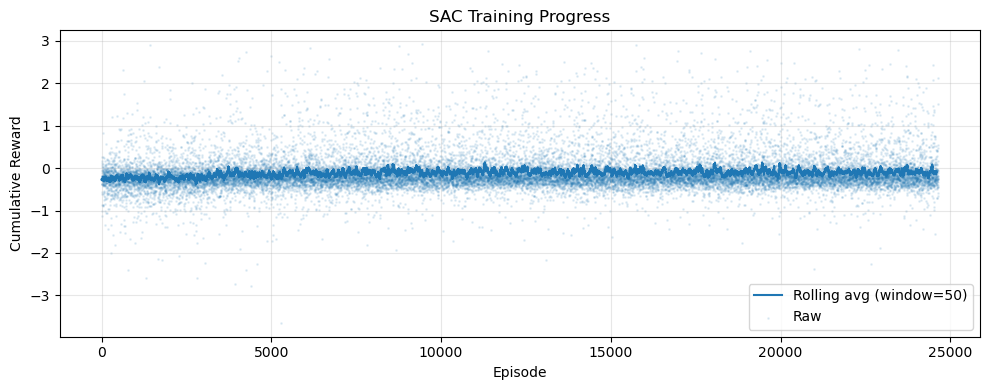

In [6]:
# Plot training progress
fig, ax = plt.subplots(figsize=(10, 4))

rewards = training_rewards
window = 50
if len(rewards) > window:
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    ax.plot(smoothed, label=f'Rolling avg (window={window})')
    ax.scatter(range(len(rewards)), rewards, alpha=0.1, s=1, label='Raw')
else:
    ax.plot(rewards)

ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Reward')
ax.set_title('SAC Training Progress')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Evaluate Trained Model

In [7]:
# Evaluate trained SAC model
sac_results = evaluate_model(
    trained_model,
    scenario,
    n_episodes=N_EVAL_EPISODES,
    max_time=MAX_TIME,
    seed=42,
    deterministic=True,
    max_action_delay=MAX_ACTION_DELAY,
    fixed_durability=FIXED_DURABILITY,
    continuous_actions=True,
)

print_evaluation_results(sac_results, "SAC", show_minmax=True)

SAC Performance (5000 episodes, original metric):
mean=-16.52 ± 2.51  (σ=177.2, n=5000)
  min=-150.00, max=762.65
  mean time=88.4
  truncated (survived): 84/5000 (1.7%)


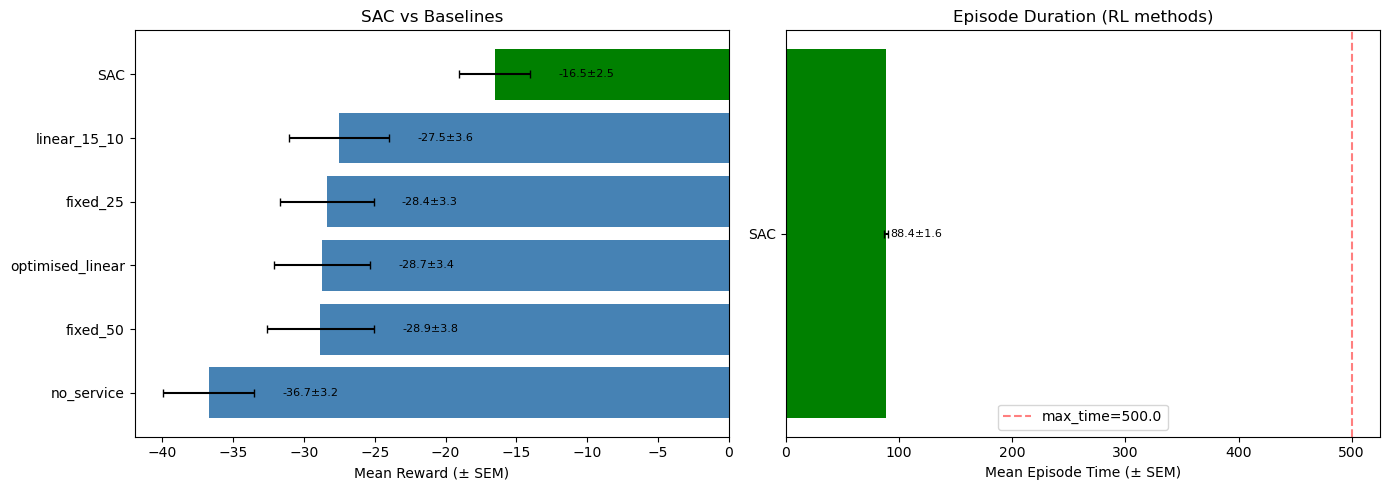

In [8]:
# Compare SAC vs baselines with error bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# === Left plot: Rewards ===
ax = axes[0]

# Collect means and SEMs for all methods
all_data = []
for name, stats in results.items():
    # Baseline std is already std of batch means ≈ SEM
    all_data.append({'name': name, 'mean': stats['mean'], 'sem': stats['std'], 'type': 'baseline'})

# SAC: compute SEM from episode rewards
sac_rewards = sac_results['rewards']
sac_sem = np.std(sac_rewards) / np.sqrt(len(sac_rewards))
all_data.append({'name': 'SAC', 'mean': np.mean(sac_rewards), 'sem': sac_sem, 'type': 'rl'})

# Sanity check (optimal with same durability)
if FIXED_DURABILITY is not None:
    sanity_rewards = sanity_results['rewards']
    sanity_sem = np.std(sanity_rewards) / np.sqrt(len(sanity_rewards))
    all_data.append({'name': 'optimal (fixed d)', 'mean': np.mean(sanity_rewards), 'sem': sanity_sem, 'type': 'optimal'})

# Sort by mean
all_data = sorted(all_data, key=lambda x: x['mean'])
names = [d['name'] for d in all_data]
means = [d['mean'] for d in all_data]
sems = [d['sem'] for d in all_data]
colors = ['green' if d['type'] == 'rl' else 'orange' if d['type'] == 'optimal' else 'steelblue' for d in all_data]

# Plot with error bars
bars = ax.barh(names, means, xerr=sems, color=colors, capsize=3)

ax.set_xlabel('Mean Reward (± SEM)')
title = 'SAC vs Baselines'
if FIXED_DURABILITY is not None:
    title += f' (fixed durability={FIXED_DURABILITY})'
ax.set_title(title)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (mean, sem) in enumerate(zip(means, sems)):
    ax.text(mean + sem + 2, i, f'{mean:.1f}±{sem:.1f}', va='center', fontsize=8)

# === Right plot: Episode Times (RL methods only) ===
ax = axes[1]

time_data = []
# SAC times
sac_times = sac_results['times']
sac_time_sem = np.std(sac_times) / np.sqrt(len(sac_times))
time_data.append({'name': 'SAC', 'mean': np.mean(sac_times), 'sem': sac_time_sem, 'type': 'rl'})

# Optimal times (sanity check)
if FIXED_DURABILITY is not None:
    sanity_times = sanity_results['times']
    sanity_time_sem = np.std(sanity_times) / np.sqrt(len(sanity_times))
    time_data.append({'name': 'optimal (fixed d)', 'mean': np.mean(sanity_times), 'sem': sanity_time_sem, 'type': 'optimal'})

# Sort by mean time
time_data = sorted(time_data, key=lambda x: x['mean'])
time_names = [d['name'] for d in time_data]
time_means = [d['mean'] for d in time_data]
time_sems = [d['sem'] for d in time_data]
time_colors = ['green' if d['type'] == 'rl' else 'orange' if d['type'] == 'optimal' else 'steelblue' for d in time_data]

# Plot with error bars
bars = ax.barh(time_names, time_means, xerr=time_sems, color=time_colors, capsize=3)

ax.set_xlabel('Mean Episode Time (± SEM)')
ax.set_title('Episode Duration (RL methods)')
ax.axvline(x=MAX_TIME, color='red', linestyle='--', alpha=0.5, label=f'max_time={MAX_TIME}')
ax.legend()

# Add value labels
for i, (mean, sem) in enumerate(zip(time_means, time_sems)):
    ax.text(mean + sem + 2, i, f'{mean:.1f}±{sem:.1f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

if FIXED_DURABILITY is not None:
    print(f"\nNote: 'optimal (fixed d)' uses same fixed_durability={FIXED_DURABILITY} as SAC.")
    print(f"      Other baselines use variable durability (not directly comparable).")

## 5. Analyse SAC Behaviour

In [9]:
# Analyse action (delay) distribution across different states
import pandas as pd

env = ServiceEnv(
    scenario, max_time=MAX_TIME, seed=42,
    max_action_delay=MAX_ACTION_DELAY,
    fixed_durability=FIXED_DURABILITY,  # Match training config
    continuous_actions=True,
)

state_actions = []
for ep in range(100):
    obs, _ = env.reset(seed=42 + ep)
    done = False
    while not done:
        action, _ = trained_model.predict(obs, deterministic=True)
        delay = float(action[0])  # Continuous action is the delay directly
        state_actions.append({
            'current_time': obs[0] * MAX_TIME,
            'last_interval': obs[1] * MAX_TIME,
            'service_count': obs[2] * 100,
            'avg_interval': obs[3] * MAX_TIME,
            'durability': obs[4] * 10,
            'delay': delay
        })
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

df = pd.DataFrame(state_actions)

print("Delay statistics:")
print(f"  Mean: {df['delay'].mean():.1f}")
print(f"  Std:  {df['delay'].std():.1f}")
print(f"  Min:  {df['delay'].min():.1f}")
print(f"  Max:  {df['delay'].max():.1f}")
print(f"\nTotal decisions: {len(df)}")

# Optimal: 24.2 + 24.2 * 1.0 = 48.4 for durability=1.0
if FIXED_DURABILITY is not None:
    print(f"\nOptimal delay for durability={FIXED_DURABILITY}: {24.2 + 24.2 * FIXED_DURABILITY:.1f}")
else:
    print("\nOptimal delay varies with durability: 24.2 + 24.2 * durability")

Delay statistics:
  Mean: 28.0
  Std:  17.7
  Min:  15.4
  Max:  59.6

Total decisions: 391

Optimal delay varies with durability: 24.2 + 24.2 * durability


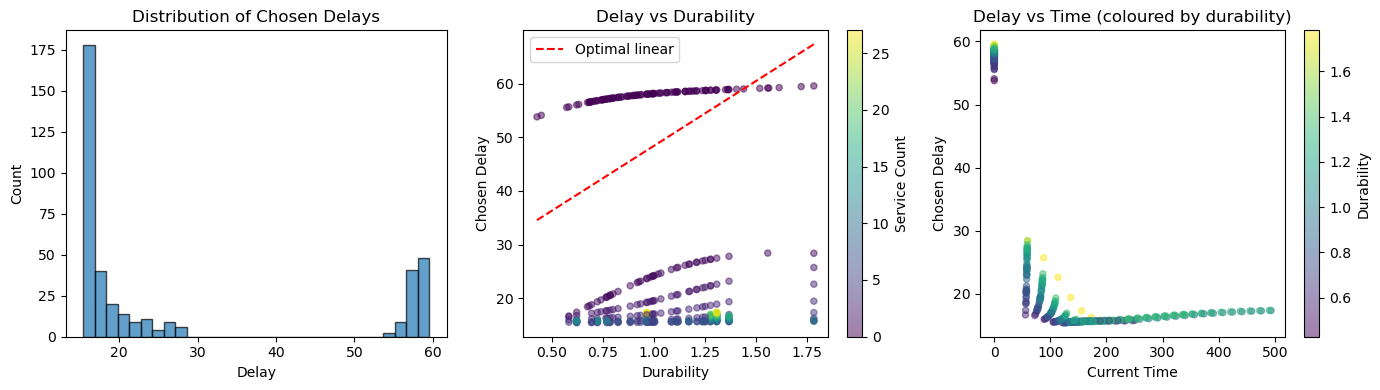

In [10]:
# Plot delay distribution and relationships
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histogram of delays
ax = axes[0]
ax.hist(df['delay'], bins=30, edgecolor='black', alpha=0.7)
if FIXED_DURABILITY is not None:
    opt_delay = 24.2 + 24.2 * FIXED_DURABILITY
    ax.axvline(opt_delay, color='red', linestyle='--', label=f'Optimal ({opt_delay:.1f})')
    ax.legend()
ax.set_xlabel('Delay')
ax.set_ylabel('Count')
ax.set_title('Distribution of Chosen Delays')

# Delay vs durability (only meaningful if durability varies)
ax = axes[1]
if FIXED_DURABILITY is not None:
    # With fixed durability, show delay vs service_count instead
    ax.scatter(df['service_count'], df['delay'], alpha=0.5, s=20)
    ax.axhline(24.2 + 24.2 * FIXED_DURABILITY, color='red', linestyle='--', label='Optimal')
    ax.set_xlabel('Service Count')
    ax.set_ylabel('Chosen Delay')
    ax.set_title(f'Delay vs Service Count (durability={FIXED_DURABILITY})')
    ax.legend()
else:
    # Colour by service count to show progression within episodes
    scatter = ax.scatter(df['durability'], df['delay'], c=df['service_count'], alpha=0.5, s=20, cmap='viridis')
    plt.colorbar(scatter, ax=ax, label='Service Count')
    # Plot optimal linear policy for reference
    d_range = np.linspace(df['durability'].min(), df['durability'].max(), 50)
    ax.plot(d_range, 24.2 + 24.2 * d_range, 'r--', label='Optimal linear')
    ax.set_xlabel('Durability')
    ax.set_ylabel('Chosen Delay')
    ax.set_title('Delay vs Durability')
    ax.legend()

# Delay vs time (colour by durability if variable, else service_count)
ax = axes[2]
if FIXED_DURABILITY is None:
    scatter = ax.scatter(df['current_time'], df['delay'], c=df['durability'], alpha=0.5, s=20, cmap='viridis')
    plt.colorbar(scatter, ax=ax, label='Durability')
    ax.set_title('Delay vs Time (coloured by durability)')
else:
    scatter = ax.scatter(df['current_time'], df['delay'], c=df['service_count'], alpha=0.5, s=20, cmap='viridis')
    plt.colorbar(scatter, ax=ax, label='Service Count')
    ax.set_title('Delay vs Time (coloured by service count)')
ax.set_xlabel('Current Time')
ax.set_ylabel('Chosen Delay')

plt.tight_layout()
plt.show()

## 6. Save Model

In [11]:
# Save trained model
model_path = '../models/sac_service_policy'
trained_model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/sac_service_policy


## Experimental Notes

Observations with current setup (100k timesteps, current hyperparameters):

### Fixed durability (durability = 1.0)

- **Base env (no variance reduction)**: Learning also works, similar to MultiSampleServiceEnv but much noisier training curves
- **Solution quality**: Comparable to variance-reduced training
- **Trade-off**: Finds solutions with lower episode length and fewer services (different Pareto trade-off than optimal linear policy)

### Variable durability (FIXED_DURABILITY = None)

- **Learning**: Struggles more than fixed durability case
- **Solution quality**: Possibly not quite as good (difficult to assess given noise)
- **Behaviour**: Finds quite different solution compared to optimal linear policy — again with lower episode lengths and fewer services
- **Interpretation**: Agent may be learning a more conservative policy that accepts earlier failures in exchange for fewer service costs